In [4]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta

def fetch_noaa_data(api_key, year):
    base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": api_key}
    location_id = "ZIP:80249"
    dataset_id = "GHCND"
    units = "standard"
    limit = 1000

    start_date_winter = f"{year - 1}-12-15"
    end_date_winter = f"{year}-01-21"

    params = {
        "datasetid": dataset_id,
        "locationid": location_id,
        "units": units,
        "startdate": start_date_winter,
        "enddate": end_date_winter,
        "limit": limit,
    }

    try:
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status()

        data = response.json()

        if "results" in data:
            filename = f"data/winter_{year - 1}-{year}.json"
            with open(filename, "w") as file:
                file.write(json.dumps(data, indent=4))
        else:
            print(f"No data for {year}")
    except requests.exceptions.HTTPError as errh:
        print("HTTP Error:", errh)
    except requests.exceptions.RequestException as err:
        print("Request Error:", err)
    except json.JSONDecodeError as json_err:
        print("JSON Decode Error:", json_err)
        print("Response content:", response.text)

for year in range(2008, 2023):
    fetch_noaa_data("BneKBmdeYUTGiHJVdrfGKkPrWaadjTxb", year)

HTTP Error: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP%3A80249&units=standard&startdate=2017-12-15&enddate=2018-01-21&limit=1000
HTTP Error: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP%3A80249&units=standard&startdate=2020-12-15&enddate=2021-01-21&limit=1000


In [27]:
import os
import json
import pandas as pd
from datetime import datetime

data_list = []

for year in range(2008, 2022):
    filename = f"data/winter_{year}-{year + 1}.json"

    if os.path.exists(filename):
        with open(filename, 'r') as file:
            json_data = json.load(file)

            temperature_data = {}

            for result in json_data['results']:
                date_str = result['date']
                value = result['value']

                if date_str not in temperature_data:
                    temperature_data[date_str] = {'TMIN': value, 'TMAX': value}
                else:
                    temperature_data[date_str]['TMIN'] = min(temperature_data[date_str]['TMIN'], value)
                    temperature_data[date_str]['TMAX'] = max(temperature_data[date_str]['TMAX'], value)

            for date, temperatures in temperature_data.items():
                tavg = (temperatures['TMIN'] + temperatures['TMAX']) / 2
                date_formatted = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").strftime("%Y-%m-%d")
                data_list.append({'date': date_formatted, 'TMIN': temperatures['TMIN'], 'TMAX': temperatures['TMAX'], 'TAVG': tavg})

df = pd.DataFrame(data_list)

df.to_csv('data/all_data_max_min_avg.csv', index=False)

In [34]:
import pandas as pd

df = pd.read_csv('data/all_data_max_min_avg.csv')

df['year'] = df['date'].apply(lambda x: x.split('-')[0])

df['month_day'] = df['date'].apply(lambda x: x[5:])

pivot_table = df.pivot(index='month_day', columns='year', values='TAVG')

pivot_table = pivot_table[::-1]

pivot_table.to_csv('data/all_data_min.csv')

print("Transformation, sorting, and saving completed.")

Transformation, sorting, and saving completed.


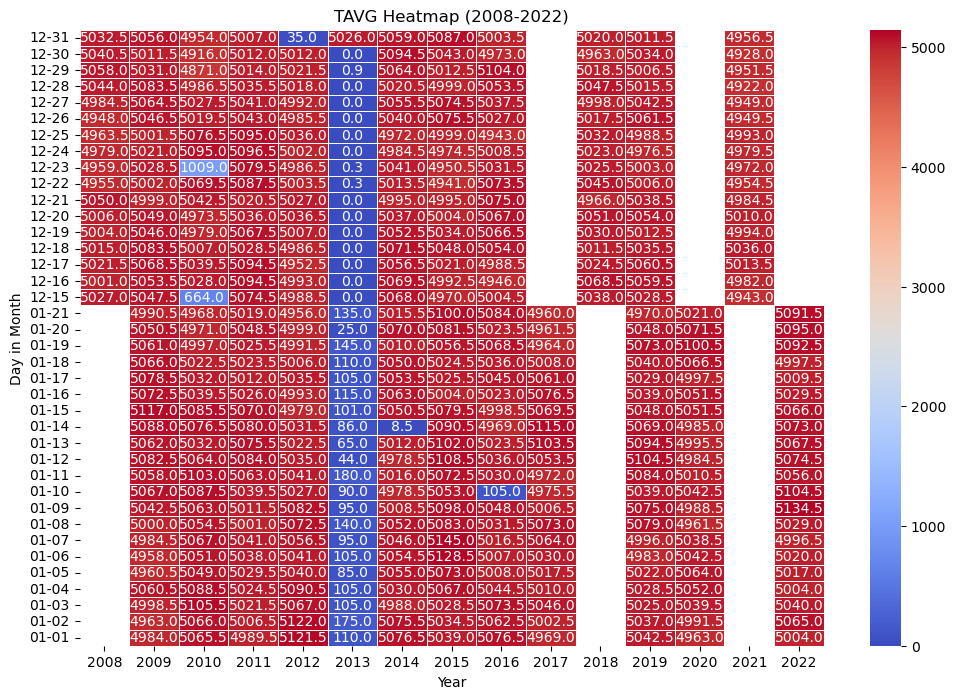

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_heatmap = pd.read_csv('data/all_data_min.csv', index_col='month_day')

plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)

plt.title('TAVG Heatmap (2008-2022)')
plt.xlabel('Year')
plt.ylabel('Day in Month')

plt.show()